
# MODEL 2: RNN (LSTM/GRU) on MediaPipe landmarks (CSV features)
 Uses the SAME CSV you used for Model 1 (SVM).

 #### Key idea:
 - Your 63 features can be treated as a sequence of 21 landmarks,
   each landmark has 3 values (x,y,z)  => (timesteps=21, features=3)
 - Then we can train an RNN (LSTM/GRU) for classification.

 #### Outputs:
 - model2_rnn_landmarks.keras
 - model2_confusion_matrix_rnn.png
 - model2_rnn_metrics.csv
 - model2_label_encoder.joblib


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

### CONFIG (EDIT PATH)

In [45]:
DATA_PATH = r"C:\Users\Vartotojas\Documents\AIA Project 2\asl_landmarks_final.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.20

EPOCHS = 96
BATCH_SIZE = 64
RNN_TYPE = "LSTM"  # "LSTM" or "GRU"

possible_label_cols = ["label", "Label", "class", "Class", "sign", "Sign", "gesture", "Gesture", "letter", "Letter"]

#### 1) LOAD DATASET

In [46]:
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)
print(df.head())

Loaded dataset: (2203, 64)
         x0        y0            z0        x1        y1        z1        x2  \
0  0.302490  0.495331 -4.277665e-07  0.401974  0.430925 -0.032561  0.477837   
1  0.765451  0.343823 -3.595415e-07  0.847147  0.297660 -0.020126  0.900564   
2  0.354618  0.851986 -5.631421e-07  0.456605  0.802520 -0.032938  0.531164   
3  0.508807  0.903747 -4.856587e-07  0.601312  0.872814 -0.048935  0.698089   
4  0.424728  0.795478 -5.605922e-07  0.571597  0.744283 -0.063864  0.700230   

         y2        z2        x3  ...       x18       y18       z18       x19  \
0  0.337875 -0.043061  0.478437  ...  0.213375  0.267955 -0.066850  0.231382   
1  0.220337 -0.024878  0.908948  ...  0.702640  0.151641 -0.048588  0.717729   
2  0.713107 -0.044213  0.533721  ...  0.292963  0.614532 -0.061759  0.306808   
3  0.763118 -0.064034  0.720130  ...  0.421785  0.662791 -0.088294  0.430163   
4  0.593906 -0.080447  0.721148  ...  0.309938  0.437413 -0.105951  0.333689   

        y19      

#### 2) DETECT LABEL + FEATURE COLS

In [47]:
label_col = next((c for c in possible_label_cols if c in df.columns), None)
if label_col is None:
    raise ValueError(
        "Label column not found. Rename your label column to one of: "
        + ", ".join(possible_label_cols)
    )
print("Label column:", label_col)

feature_cols = [c for c in df.columns if c != label_col and pd.api.types.is_numeric_dtype(df[c])]
if len(feature_cols) < 63:
    raise ValueError(f"Expected at least 63 numeric features, found {len(feature_cols)}. Check your dataset columns.")

# Use only the first 63 numeric features (if you have extra engineered features)
feature_cols = feature_cols[:63]
print("Using numeric feature columns:", len(feature_cols))

X = df[feature_cols].to_numpy(dtype=np.float32)
y_raw = df[label_col].astype(str).to_numpy()

print("X shape (flat):", X.shape)

Label column: label
Using numeric feature columns: 63
X shape (flat): (2203, 63)


#### 3) LABEL ENCODING

In [48]:
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))
print("Num classes:", num_classes)

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']
Num classes: 28


#### 4) TRAIN/TEST SPLIT (STRATIFIED)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1762, 63) Test: (441, 63)


#### 5) STANDARDIZE FEATURES (fit on train only)

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler too (important for deployment)
joblib.dump(scaler, "model2_scaler.joblib")
print("Saved scaler: model2_scaler.joblib")

Saved scaler: model2_scaler.joblib


#### 6) RESHAPE FOR RNN: (N, 63) -> (N, 21, 3)
 Assumption: 63 = 21 landmarks * 3 coords (x,y,z)

In [51]:
def to_sequence(x_flat: np.ndarray) -> np.ndarray:
    if x_flat.shape[1] != 63:
        raise ValueError(f"Expected 63 features for reshaping, got {x_flat.shape[1]}")
    return x_flat.reshape((-1, 21, 3))

X_train_seq = to_sequence(X_train_scaled)
X_test_seq  = to_sequence(X_test_scaled)

print("X_train_seq shape:", X_train_seq.shape)

X_train_seq shape: (1762, 21, 3)


#### 7) BUILD RNN MODEL (LSTM/GRU)

In [52]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(21, 3))

# Small feature extractor before RNN (optional but helpful)
x = layers.Dense(32, activation="relu")(inputs)

if RNN_TYPE.upper() == "GRU":
    x = layers.GRU(64, return_sequences=False)(x)
else:
    x = layers.LSTM(64, return_sequences=False)(x)

x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model2 = models.Model(inputs, outputs, name=f"model2_{RNN_TYPE.upper()}")

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model2.summary()

Model: "model2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,940 (120.86 KB)

 Trainable params: 30,940 (120.86 KB)

 Non-trainable params: 0 (0.00 B)

#### 8) TRAIN

In [53]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
]

history = model2.fit(
    X_train_seq, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0568 - loss: 3.3041 - val_accuracy: 0.0717 - val_loss: 3.2617 - learning_rate: 0.0010
Epoch 2/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0888 - loss: 3.2071 - val_accuracy: 0.0981 - val_loss: 3.1609 - learning_rate: 0.0010
Epoch 3/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1276 - loss: 3.0644 - val_accuracy: 0.1283 - val_loss: 2.9922 - learning_rate: 0.0010
Epoch 4/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1583 - loss: 2.9235 - val_accuracy: 0.1623 - val_loss: 2.7845 - learning_rate: 0.0010
Epoch 5/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1817 - loss: 2.7328 - val_accuracy: 0.2151 - val_loss: 2.5856 - learning_rate: 0.0010
Epoch 6/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2084 - loss: 2.6028 - val_accuracy: 0.2642 - val_loss: 2.4396 - learning_rate: 0.0010
Epoch 7/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2365 - loss: 2.4588 - val_accuracy:

#### 9) TEST EVALUATION

In [54]:
y_prob = model2.predict(X_test_seq, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
print("\nModel2 Test Accuracy:", acc)

labels_all = np.arange(num_classes)
print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred,
    labels=labels_all,
    target_names=le.classes_,
    digits=4,
    zero_division=0
))


Model2 Test Accuracy: 0.7482993197278912

Classification Report:

              precision    recall  f1-score   support

           A     0.8000    0.5714    0.6667        14
           B     0.7059    0.8571    0.7742        14
           C     0.8333    0.7692    0.8000        13
           D     0.7500    0.8333    0.7895        18
           E     0.9375    0.8824    0.9091        17
           F     0.7778    0.7000    0.7368        20
           G     0.8824    0.9375    0.9091        16
           H     0.8333    0.8824    0.8571        17
           I     0.8750    1.0000    0.9333        14
           J     0.7097    0.8462    0.7719        26
           K     0.8500    0.9444    0.8947        18
           L     0.7000    0.9333    0.8000        15
           M     0.7143    0.4545    0.5556        11
           N     0.5000    0.7500    0.6000         8
           O     0.7333    0.6875    0.7097        16
           P     0.7692    0.7143    0.7407        14
           Q  

#### 10) CONFUSION MATRIX + PER-CLASS RECALL

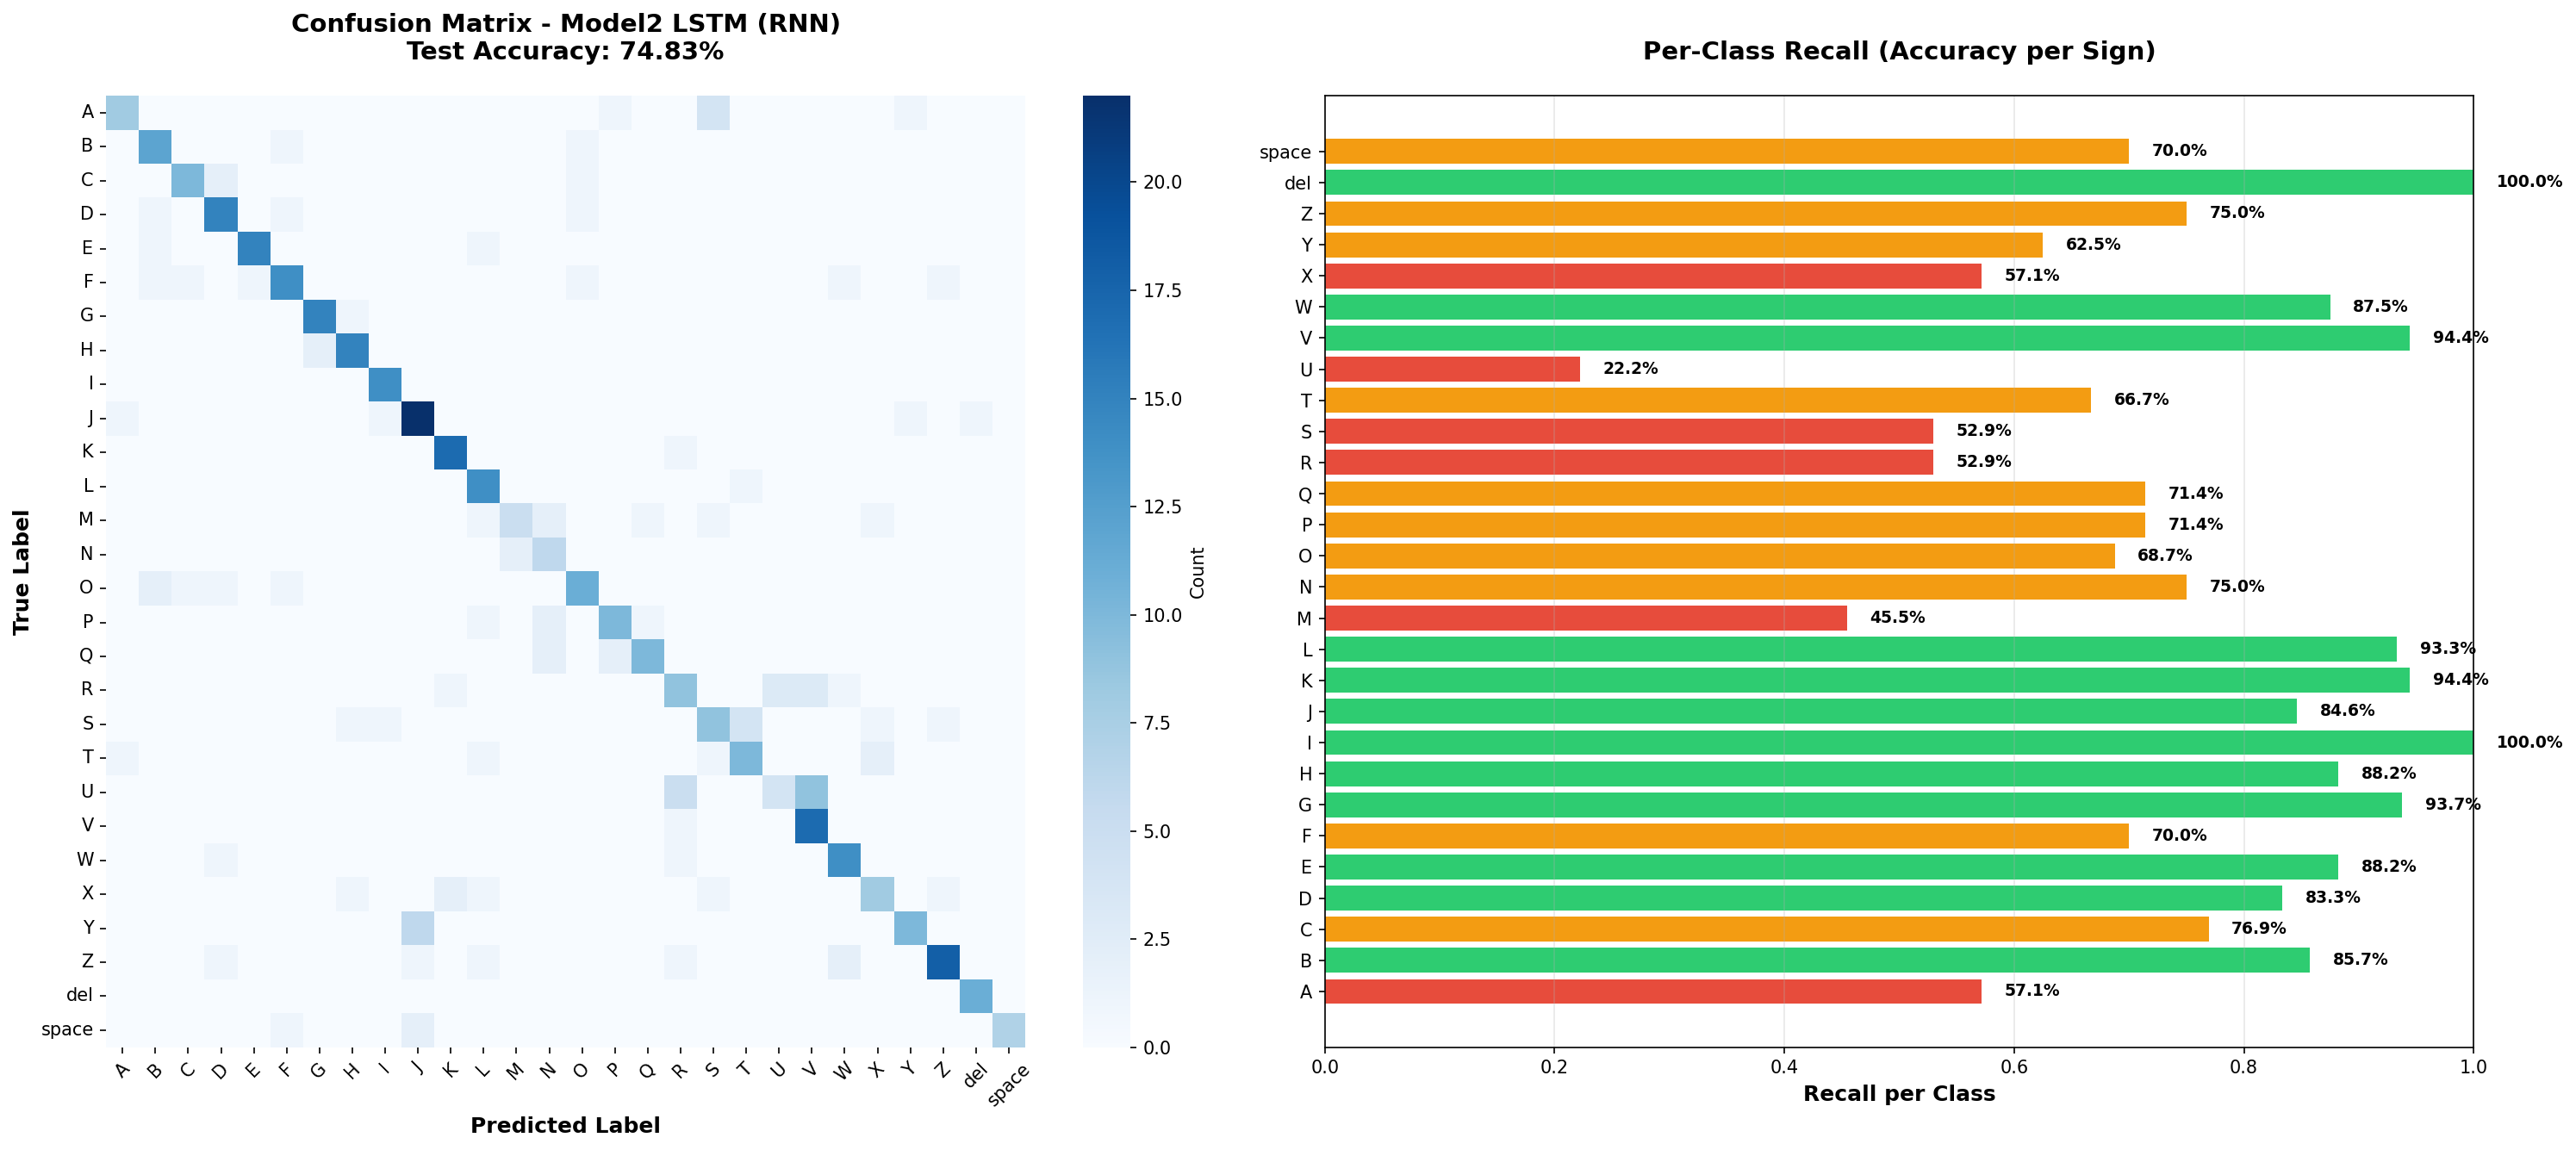

Saved: model2_confusion_matrix_rnn.png


In [55]:
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
recall_per_class = np.diag(cm) / (cm.sum(axis=1) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(20, 9), dpi=150)

# Confusion matrix
ax1 = axes[0]
sns.heatmap(
    cm, cmap="Blues", annot=False,
    xticklabels=le.classes_, yticklabels=le.classes_,
    cbar_kws={"label": "Count"}, ax=ax1
)
ax1.set_xlabel("Predicted Label", fontsize=12, fontweight="bold")
ax1.set_ylabel("True Label", fontsize=12, fontweight="bold")
ax1.set_title(f"Confusion Matrix - Model2 {RNN_TYPE.upper()} (RNN)\nTest Accuracy: {acc*100:.2f}%",
              fontsize=14, fontweight="bold", pad=20)
ax1.tick_params(axis="x", rotation=45)

# Per-class recall
ax2 = axes[1]
colors = ['#2ecc71' if x > 0.8 else '#f39c12' if x > 0.6 else '#e74c3c'
          for x in recall_per_class]
ax2.barh(le.classes_, recall_per_class, color=colors)
ax2.set_xlabel("Recall per Class", fontsize=12, fontweight="bold")
ax2.set_title("Per-Class Recall (Accuracy per Sign)", fontsize=14, fontweight="bold", pad=20)
ax2.set_xlim(0, 1)
ax2.grid(axis="x", alpha=0.3)

for i, val in enumerate(recall_per_class):
    ax2.text(val + 0.02, i, f"{val*100:.1f}%", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.savefig("model2_confusion_matrix_rnn.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: model2_confusion_matrix_rnn.png")


#### 11) SAVE METRICS CSV

In [56]:
metrics_df = pd.DataFrame({
    "Class": le.classes_,
    "Recall": recall_per_class,
    "Total_Samples": cm.sum(axis=1),
    "Correct_Predictions": np.diag(cm)
})
metrics_df["Recall_Percent"] = metrics_df["Recall"] * 100

overall = pd.DataFrame([{
    "Class": "OVERALL",
    "Recall": acc,
    "Total_Samples": int(cm.sum()),
    "Correct_Predictions": int(np.diag(cm).sum()),
    "Recall_Percent": acc * 100
}])

metrics_df = pd.concat([metrics_df, overall], ignore_index=True)
metrics_df.to_csv("model2_rnn_metrics.csv", index=False)
print("Saved: model2_rnn_metrics.csv")


Saved: model2_rnn_metrics.csv


#### 12) SAVE MODEL + LABEL ENCODER

In [57]:
model2.save("model2_rnn_landmarks.keras")
joblib.dump(le, "model2_label_encoder.joblib")
print("Saved model: model2_rnn_landmarks.keras")
print("Saved label encoder: model2_label_encoder.joblib")

Saved model: model2_rnn_landmarks.keras
Saved label encoder: model2_label_encoder.joblib
